In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
plt.rcParams["savefig.dpi"] = 300
plt.rcParams["savefig.bbox"] = 'tight'
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.simplefilter('ignore', (FutureWarning, ConvergenceWarning))

# Feature importances and Model interpretation



## Model Interpretation and Feature Selection

03/04/20

Andreas C. Müller



Alright, everybody. Today we will talk about
Feature selection and model interpretation, look at how to do this in general,
and how to doit with scikit-learn. We're also going to look into a couple
of other Python libraries that help doing these two things.


FIXME motivation for model interpretation!
FIXME random forest code is confusing because I tried to simplify it. Also: we haven't seen those yet?!

FIXME use / explain permutation importance

FIXME use seaborn clustermap for correlation matrix plot

FIXME add diagram for permutation importance
FIXME explain when and how to interpret coeffients
FIXME mutual information needs better explanation
FIXME lasso show random between correlated, same for tree, compare to RF
FIXME IceBOX example with cross?
FIXME should be two lectures really!
FIXME maybe drop shap and shaply
FIXME better explanation for ice-box and partial dependence
FIXME partial dependence definitely needs a process diagram
FIXME remove boston
FIXME icebox do real simpsons paradox example
FIXME unsupervised feature selection terrible?
FIXME why is shap in the wrong direction? Why spurious importances?


## Model Interpretation (post-hoc)?

- ### Not inference!
- ### Not causality!
- ### still useful(?)



Possibly useful for feature selection, feature engineering, model debugging, explaining predictions.
Alternatively: use model that are easy to interpret!
OR: derive a simpler explainable model from a non-explainable one (model compression)

Caveat: if your model is bad, interpreting it makes no sense!

## Types of explanations

##Explain model globally
- How does the output depend on the input?
- Often: some form of marginals


### Explain model locally
- Why did it classify this point this way?
- Explanation could look like a "global" one but be different for each point.
- "What is the minimum change to classify it differently?"



Marginals: how does the prediction change as function of a particular Features?

## Explaning the model $\neq$ explaining the data

- model inspection only tells you about the model
- the model might not accurately reflect the data

## "Features important to the model"?

Naive:
- `coef_` for linear models (abs value or norm for multi-class)
- `feature_importances_` for tree-based models

Use with care!

## Linear Model coefficients
- Relative importance only meaningful after scaling
- Correlation among features might make coefficients completely uninterpretable
- L1 regularization will pick one at random from a correlated group
- Any penalty will invalidate usual interpretation of linear coefficients

## Drop Feature Importance

$$I_i^\text{drop} = \text{Acc}(f, X, y) - \text{Acc}(f', X_{-i}, y)$$

.smallest[
```python
def drop_feature_importance(est, X, y):
    base_score = np.mean(cross_val_score(est, X, y))
    scores = []
    for feature in range(X.shape[1]):
        mask = np.ones(X.shape[1], 'bool')
        mask[feature] = False
        X_new = X[:, mask]
        this_score = np.mean(cross_val_score(est, X_new, y))
        scores.append(base_score - this_score)
    return np.array(scores)
```]
.smallest[
- Doesn't really explain model (refits for each feature)
- Can't deal with correlated features well
- Very slow
- Can be used for feature selection
]


on it's own not very useful, we'll see it later
rebuilds many models, not explaining this particular model!
+++
## Permutation importance
Idea: measure marginal influence of one feature

$$I_i^\text{perm} = \text{Acc}(f, X, y) - \mathbb{E}_{x_i}\left[\text{Acc}(f(x_i, X_{-i}), y)\right]$$

```python
def permutation_importance(est, X, y, n_repeat=100):
  baseline_score = estimator.score(X, y)
  for f_idx in range(X.shape[1]):
      for repeat in range(n_repeat):
          X_new = X.copy()
          X_new[:, f_idx] = np.random.shuffle(X[:, f_idx])
          feature_score = estimator.score(X_new, y)
          scores[f_idx, repeat] = baseline_score - feature_score
```

--

- Applied on validation set given trained estimator.
- Also kinda slow.

## LIME
.smaller[
- Build sparse linear local model around each data point.
- Explain prediction for each point locally.
- Paper: "Why Should I Trust You?" Explaining the Predictions of Any Classifier
- Implementation: ELI5, https://github.com/marcotcr/lime
]

.center[
![:scale 60%](images/lime_paper.png)
]

## SHAP
- Build around idea of Shaply values
- very roughly: does drop-out importance for every subset of features
- intractable, sampling approximations exists
- fast variants for linear and tree-based models
- awesome vis and tools: https://github.com/slundberg/shap
- allows local / per sample explanations


## Case Study

## Toy data
```python
X.shape
```
```
(100000, 8)
```
.wide-left-column[
![:scale 100%](images/toy_data_scatter.png)

]
.narrow-right-column[
![:scale 100%](images/covariance.png)

]

## Models on lots of data
.smallest[
```python
lasso = LassoCV().fit(X_train, y_train)
lasso.score(X_test, y_test)
```
0.545
```python
ridge = RidgeCV().fit(X_train, y_train)
ridge.score(X_test, y_test)
```
0.545

```python
lr = LinearRegression().fit(X_train, y_train)
lr.score(X_test, y_test)
```
0.545
```python
param_grid = {'max_leaf_nodes': range(5, 40, 5)}
grid = GridSearchCV(DecisionTreeRegressor(), param_grid, cv=10, n_jobs=3)
grid.fit(X_train, y_train)
grid.score(X_test, y_test)
```
0.545
```python
rf = RandomForestRegressor(min_samples_leaf=5).fit(X_train, y_train)
rf.score(X_test, y_test)
```
0.542
]

## Coefficients and default feature importance
![:scale 100%](images/standard_importances.png)


- tree and RF have no directionality in importances
- lasso (and to some degree tree) selected randomly among correlated
- RF assigns high importance to random features

## Permutation Importances
.center[
![:scale 50%](images/standard_importances.png)
![:scale 50%](images/permutation_importance_big.png)
]

## SHAP values
.center[
![:scale 50%](images/standard_importances.png)
![:scale 50%](images/shap_big.png)
]

## More model inspection

## Partial Dependence Plots
- Marginal dependence of prediction on one (or two features)

$$f_i^{\text{pdp}}(x_i) = \mathbb{E}_{X_{-i}}\left[f(x_i, x_{-i})\right]$$

- Idea: Get marginal predictions given feature.
- How? "integrate out" other features using validation data
- Fast methods available for tree-based models (doesn't require validation data)
- Nonsensical for linear models.

## Partial Dependence
.tiny[
```python
from sklearn.inspection import plot_partial_dependence
boston = load_boston()
X_train, X_test, y_train, y_test = train_test_split(boston.data, boston.target,random_state=0)

gbrt = GradientBoostingRegressor().fit(X_train, y_train)

fig, axs = plot_partial_dependence(gbrt, X_train, np.argsort(gbrt.feature_importances_)[-6:], feature_names=boston.feature_names)
```
]

--

.center[
![:scale 60%](images/feat_impo_part_dep.png)
]



But there's also something else that's quite interesting,
which is called Partial Dependence Plots that's actually
possible for all trees. Unfortunately, in scikit-learn, it’s
available only for the gradient boosting. So the idea here
is to not only see what parameters are important but how
will they influence the target. And so after you fit your
model, I'm using the Boston data set to the gradient
boosting regressor, there's a thing called plot partial
dependence, which gets the model and the training data set
and then the features for which I want to make the partial
dependence plots.

So here, I'm looking at the six most important features. The
feature importance is important according to the trees. So I
sort this and take the six most important ones.

And so this is what the partner dependence plots look like.
So this is the most important feature, the second most
important feature and so on. This is sort of the marginal
contribution of each feature. Basically, in each tree,
you're summing out the contribution of all the other
features, and you look only at what is the contribution of
this particular feature. In general, this would be hard to
compute. For tree-based models you can compute is a very
efficient way because you can basically just sum up over the
whole space by traversing the tree.

Here with increased room size, the price increases and you
can see how it increases and you can see that there's like a
big step function here. And you can see that for increased
LSTAT, the price decreases. For the others, there aren’t any
drastic effect. There seems to be some threshold for NOX.
And something funky going on DIS.

The question is, so I said for random forest, you can't find
out the direction of which way the feature influences. But
that was for the feature importance. So the feature
importance tells the impurity decrease. So here I also look
at the feature importance and they're just numbers so they
don't give you the direction. For both gradient boosting and
random forest, you can look at partial dependency plot, and
they will give you a non-parametric model of how a single
feature influences it. Unfortunately, it’s not available in
scikit-learn. You could do the same thing for random
forests. Because in the end, the way they predict is quite
similar.

## Bivariate Partial Dependence Plots
.smaller[
```python
plot_partial_dependence(
    gbrt, X_train, [np.argsort(gbrt.feature_importances_)[-2:]],
    feature_names=boston.feature_names, n_jobs=3, grid_resolution=50)
```
]
.center[
![:scale 80%](images/feature_importance.png)
]



You can also do this in bivariate. So here, looking at the
two most important features in a bivariate plot, I'm
actually not giving it a list of features, but I'm giving it
a list of list of features. And so the two most important
features, LSTAT, and ROOM.

You can see there’s no very complex interaction. As you can
see, the effect of these two features taking into account
all the other features.

This is something you can usually do for linear model
easily. If you do this for the linear model, you would have
lines everywhere but for more complicated models this is
very hard to do. Way more tricky to do in neural networks.

## Partial Dependence for Classification
.tiny-code[
```python
from sklearn.inspection import plot_partial_dependence
for i in range(3):
    fig, axs = plot_partial_dependence(gbrt, X_train, range(4), n_cols=4,
                                       feature_names=iris.feature_names, grid_resolution=50, label=i)
```
]
.center[
![:scale 50%](images/feat_impo_part_dep_class.png)
]


We can do the same for classification. Here is a partial
dependency plot for the iris dataset.

As I said, for classification we’re usually using One Versus
Rest. So here, we have three classifiers.

One classifier for sertosa, one for Versicolor and one for
virginica.

You can see that for the first two features they're like
flat. But for sertosa the decision function is high for
small part petal length, medium peddling for versicolor and
large for virginca. These are all put through logistic
function and then normalized.

## PDP Caveats
.left-column[
![:scale 100%](images/pdp_failure.png)
]
--
.right-column[
![:scale 100%](images/pdp_failure_data.png)
]

## Ice Box
.smaller[
- like partial dependence plots, without the `.mean(axis=0)`
]

.center[
![:scale 60%](images/ice_cross.png)
]
.tiny[
- https://pdpbox.readthedocs.io/en/latest/
- https://github.com/AustinRochford/PyCEbox
- https://github.com/scikit-learn/scikit-learn/pull/16164
]

In [2]:
# generate data from original 2d linear model
from sklearn.preprocessing import scale

# 35 13 50? 
rng = np.random.RandomState(13)
n_samples = 100000
n_informative = 2
n_correlated_per_inf = 2
n_noise = 4
noise_std = .0001
noise_correlated_std = .51
noise_y = .3


X_original = rng.uniform(-1, 1, size=(n_samples, n_informative))
#coef = rng.normal(size=n_informative)
coef = np.array([-3.2, 1.4])
y = np.dot(X_original, coef) + rng.normal(scale=noise_y, size=n_samples)

correlated_transform = np.zeros((n_correlated_per_inf * n_informative, n_informative))
for i in range(n_informative):
    correlated_transform[i * n_correlated_per_inf: (i + 1) * n_correlated_per_inf, i] = rng.normal(size=n_correlated_per_inf)
X_original += rng.normal(scale=np.array([1, 1]) * noise_correlated_std, size=X_original.shape)
X_correlated = np.dot(X_original, correlated_transform.T)

X = np.hstack([X_correlated, np.zeros((n_samples, n_noise))])
X += rng.normal(scale=noise_std, size=X.shape)
X = scale(X)

In [3]:
X.shape

(100000, 8)

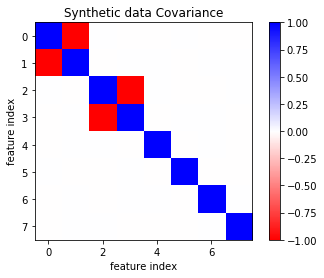

In [4]:
plt.imshow(np.cov(X, rowvar=False), cmap='bwr_r')
plt.title("Synthetic data Covariance")
plt.xlabel("feature index")
plt.ylabel("feature index")
plt.colorbar()
plt.savefig("images/covariance.png")


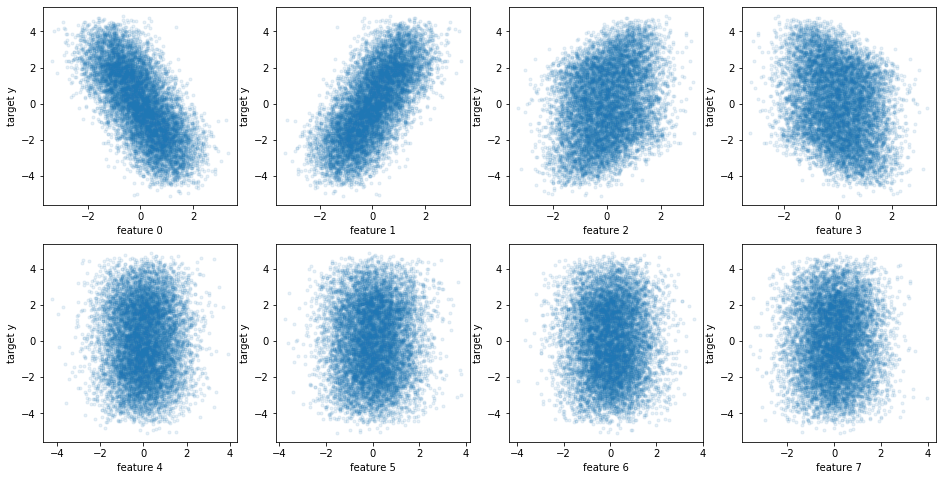

In [5]:
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
for i, ax in enumerate(axes.ravel()):
    ax.plot(X[::10, i], y[::10], '.', alpha=.1)
    ax.set_xlabel("feature {}".format(i))
    ax.set_ylabel("target y")
plt.savefig("images/toy_data_scatter.png")

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [7]:
from sklearn.linear_model import LassoCV, RidgeCV, LinearRegression

for i in range(X.shape[1]):
    lr = LinearRegression().fit(X_train[:, [i]], y_train)
    print(lr.score(X_test[:, [i]], y_test))

0.4532506867871262
0.4532514261726276
0.09275569004419326
0.09275599504713594
-0.00020773972150145426
-0.00017276124646903313
-0.00018329268681771538
-0.00020494411292082404


In [8]:
lasso = LassoCV().fit(X_train, y_train)
lasso.score(X_test, y_test)

0.5453241219700229

In [9]:
ridge = RidgeCV().fit(X_train, y_train)
ridge.score(X_test, y_test)

0.5453306487434062

In [10]:
lr = LinearRegression().fit(X_train, y_train)
lr.score(X_test, y_test)

0.5453299378456281

In [11]:
from sklearn.decomposition import PCA
pca = PCA(n_components=.99).fit(X_train)
X_train_pca = pca.transform(X_train)
lr_pca = LinearRegression().fit(X_train_pca, y_train)
inverse_lr_pca_coef = pca.inverse_transform(lr_pca.coef_)
lr_pca.score(pca.transform(X_test), y_test)

0.5453305950074661

In [12]:
pca.n_components_

6

In [13]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

param_grid = {'max_leaf_nodes': range(5, 40, 5)}
grid = GridSearchCV(DecisionTreeRegressor(), param_grid, cv=10, n_jobs=3)
grid.fit(X_train, y_train)
grid.score(X_test, y_test)

0.5452326112689287

In [14]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(min_samples_leaf=5).fit(X_train, y_train)
rf.score(X_test, y_test)

0.5426645543931425

In [15]:
from sklearn.ensemble import ExtraTreesRegressor
et = ExtraTreesRegressor().fit(X_train, y_train)
et.score(X_test, y_test)

0.5216260871052119

In [16]:
def plot_importance(some_dict):
    plt.figure(figsize=(10, 4))
    df = pd.DataFrame(some_dict)
    ax = plt.gca()
    df.plot.bar(ax=ax, width=.9)
    ax.set_ylim(-1.5, 1.5)
    ax.set_xlim(-.5, len(df) - .5)
    ax.set_xlabel("feature index")
    ax.set_ylabel("importance value")
    plt.vlines(np.arange(.5, len(df) -1), -1.5, 1.5, linewidth=.5)

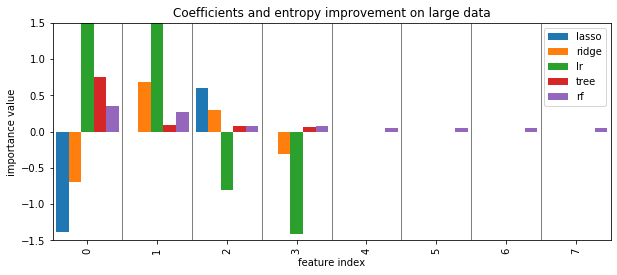

In [17]:
tree = grid.best_estimator_
plot_importance({'lasso': lasso.coef_, 'ridge': ridge.coef_, 'lr': lr.coef_, 'tree': tree.feature_importances_, 'rf':rf.feature_importances_})
plt.title("Coefficients and entropy improvement on large data")
plt.savefig("images/standard_importances.png")

In [18]:
from sklearn.model_selection import cross_val_score

def drop_feature_importance(est, X, y):
    base_score = np.mean(cross_val_score(est, X, y))
    scores = []
    for feature in range(X.shape[1]):
        mask = np.ones(X.shape[1], 'bool')
        mask[feature] = False
        X_new = X[:, mask]
        this_score = np.mean(cross_val_score(est, X_new, y))
        scores.append(base_score - this_score)
    return np.array(scores)

In [19]:
from sklearn.inspection import permutation_importance

In [20]:
perm_ridge_test = permutation_importance(ridge, X_test, y_test)['importances_mean']
perm_lasso_test = permutation_importance(lasso, X_test, y_test)['importances_mean']
perm_tree_test = permutation_importance(tree, X_test, y_test)['importances_mean']

In [21]:
perm_rf_test = permutation_importance(rf, X_test, y_test)['importances_mean']

In [25]:
perm_lr_test = permutation_importance(lr, X_test, y_test)['importances_mean']

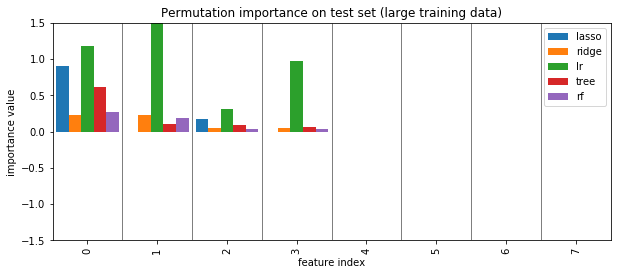

In [27]:
tree = grid.best_estimator_
plot_importance({'lasso': perm_lasso_test, 'ridge': perm_ridge_test, 'lr': perm_lr_test,'tree': perm_tree_test, 'rf':perm_rf_test})
plt.title("Permutation importance on test set (large training data)")
plt.savefig("images/permutation_importance_big.png")

In [32]:
import shap

def shap_linear(model, X_train, X_test):
    linear_explainer = shap.LinearExplainer(model, X_train)
    shap_values = linear_explainer.shap_values(X_test)
    s = shap_values.mean(axis=0)
    s /= np.linalg.norm(s)
    return s

shap_ridge = shap_linear(ridge, X_train, X_test)
shap_lasso = shap_linear(lasso, X_train, X_test)

In [33]:
def shap_trees(model, X_train, X_test, approximate=False, tree_limit=None):
    tree_explainer = shap.TreeExplainer(model, X_train)
    shap_values = tree_explainer.shap_values(X_test, approximate=approximate, tree_limit=tree_limit)
    s = shap_values.mean(axis=0)
    s /= np.linalg.norm(s)
    return s

In [34]:
shap_tree = shap_trees(tree, X_train, X_test)

Passing 75000 background samples may lead to slow runtimes. Consider using shap.sample(data, 100) to create a smaller background data set.
100%|===================| 24983/25000 [09:37<00:00]        

In [36]:
# limit trees cause I'm in a hurry
shap_forest = shap_trees(rf, X_train, X_test, approximate=True, tree_limit=None)

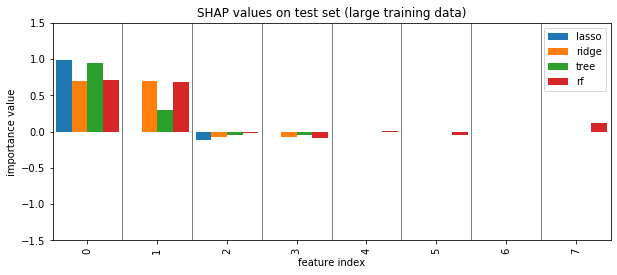

In [37]:
plot_importance({'lasso': shap_lasso, 'ridge': shap_ridge, 'tree': shap_tree, 'rf':shap_forest})
plt.title("SHAP values on test set (large training data)")
plt.savefig("images/shap_big.png")

In [34]:
# X_test is actually big, not small, but that would be confusing naming, right?
X_train_small, X_test_small, y_train_small, y_test_small = train_test_split(X, y, train_size=0.001, random_state=0)
X_train_small.shape

(100, 8)

In [35]:
lasso_small = LassoCV().fit(X_train_small, y_train_small)
lasso_small.score(X_test_small, y_test_small)

0.5361580595868876

In [36]:
ridge_small = RidgeCV().fit(X_train_small, y_train_small)
ridge_small.score(X_test_small, y_test_small)

0.5336853626423791

In [37]:
lr_small = LinearRegression().fit(X_train_small, y_train_small)
lr_small.score(X_test_small, y_test_small)

0.5262746934049003

In [38]:
from sklearn.decomposition import PCA
pca_small = PCA(n_components=.99).fit(X_train_small)
X_train_pca = pca_small.transform(X_train_small)
lr_pca_small = LinearRegression().fit(X_train_pca, y_train_small)
inverse_lr_pca_coef = pca.inverse_transform(lr_pca_small.coef_)
lr_pca_small.score(pca_small.transform(X_test_small), y_test_small)

0.5303117477435796

In [39]:
param_grid = {'max_leaf_nodes': range(2, 20)}
grid_tree_small = GridSearchCV(DecisionTreeRegressor(), param_grid, cv=10, n_jobs=3)
grid_tree_small.fit(X_train_small, y_train_small)
grid_tree_small.score(X_test_small, y_test_small)

0.34452144133533447

In [40]:
rf_small = RandomForestRegressor(min_samples_leaf=5).fit(X_train_small, y_train_small)
rf_small.score(X_test_small, y_test_small)

0.5053610963883473

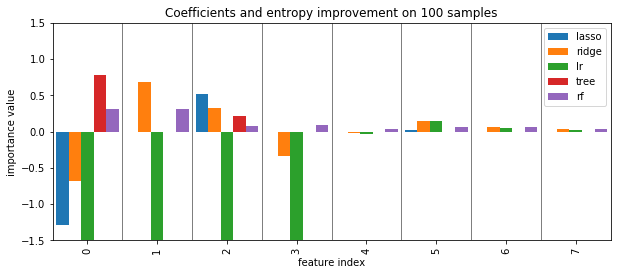

In [44]:
tree_small = grid_tree_small.best_estimator_
plot_importance({'lasso': lasso_small.coef_, 'ridge': ridge_small.coef_, 'lr': lr_small.coef_, 'tree': tree_small.feature_importances_, 'rf':rf_small.feature_importances_})
plt.title("Coefficients and entropy improvement on 100 samples")
plt.savefig("images/standard_importances_small.png")

In [47]:
perm_ridge_test_small = permutation_importance(ridge_small, X_test_small, y_test_small).mean(axis=1)
perm_lasso_test_small = permutation_importance(lasso_small, X_test_small, y_test_small).mean(axis=1)
perm_tree_test_small = permutation_importance(tree_small, X_test_small, y_test_small).mean(axis=1)

In [48]:
perm_rf_test_small = permutation_importance(rf_small, X_test_small, y_test_small).mean(axis=1)

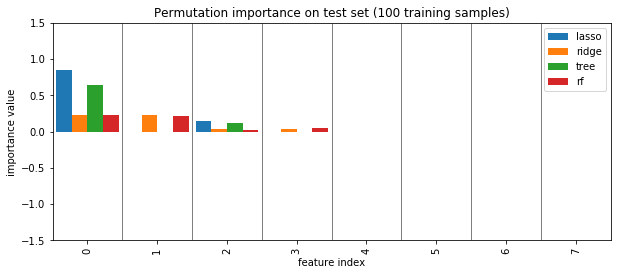

In [49]:
plot_importance({'lasso': perm_lasso_test_small, 'ridge': perm_ridge_test_small, 'tree': perm_tree_test_small, 'rf':perm_rf_test_small})
plt.title("Permutation importance on test set (100 training samples)")
plt.savefig("images/permutation_importance_small.png")

In [50]:
shap_ridge_small = shap_linear(ridge_small, X_train_small, X_test_small)
shap_lasso_small = shap_linear(lasso_small, X_train_small, X_test_small)

/home/andy/anaconda3/envs/py37/lib/python3.7/site-packages/shap/explainers/linear.py:47: UserWarning: The default value for feature_dependence has been changed to "independent"!
  warnings.warn('The default value for feature_dependence has been changed to "independent"!')


In [ ]:
shap_tree_small = shap_trees(best_tree_small, X_train_small, X_test_small)

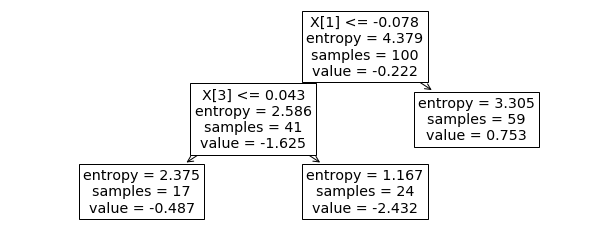

In [457]:
from sklearn.tree import plot_tree
plt.figure(figsize=(10, 4))
plot_tree(grid_tree_small.best_estimator_);

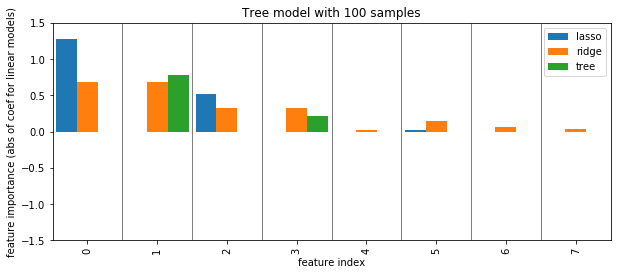

In [459]:
dt = DecisionTreeRegressor(max_leaf_nodes=3).fit(X_train_small[:, [0, 2]], y_train_small)
dt.score(X_test_small[:, [0, 2]], y_test_small)

0.34452144133533447

In [475]:
best_tree = grid_tree_small.best_estimator_
drop_tree_small = drop_feature_importance(best_tree, X_train_small, y_train_small)
perm_tree_small = permutation_importance(best_tree, X_test_small, y_test_small).mean(axis=1)

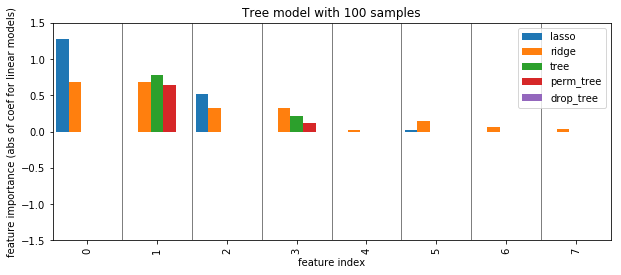

In [476]:
plot_importance({'lasso': np.abs(lasso_small.coef_), 'ridge': np.abs(ridge_small.coef_), 'tree': grid_tree_small.best_estimator_.feature_importances_,
                 'perm_tree': perm_tree_small, 'drop_tree': drop_tree_small})
plt.ylabel("feature importance (abs of coef for linear models)")
plt.title("Tree model with 100 samples")
plt.savefig("images/tree_less_data_all.png")

In [480]:
def shap_trees(model, X_train, X_test):
    tree_explainer = shap.TreeExplainer(model, X_train)
    shap_values = tree_explainer.shap_values(X_test)
    s = shap_values.mean(axis=0)
    s /= np.linalg.norm(s)
    return s

In [481]:
shap_tree_small = shap_trees(best_tree, X_train_small, X_test_small)

# Random Forest

In [482]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor().fit(X_train, y_train)
rf.score(X_test, y_test)

NameError: name 'r' is not defined

0.5359354408860038

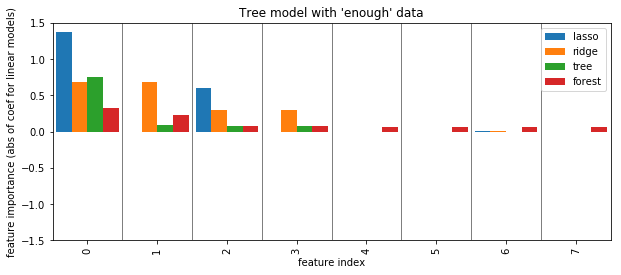

In [486]:
plot_importance({'lasso': np.abs(lasso.coef_), 'ridge': np.abs(ridge.coef_), 'tree': grid.best_estimator_.feature_importances_, 'forest': rf.feature_importances_})
plt.ylabel("feature importance (abs of coef for linear models)")
plt.title("Tree model with 'enough' data")
plt.savefig("images/forest_enough_data.png")

In [491]:
rf_small = RandomForestRegressor().fit(X_train_small, y_train_small)
rf_small.score(X_test_small, y_test_small)

0.44742420319303305

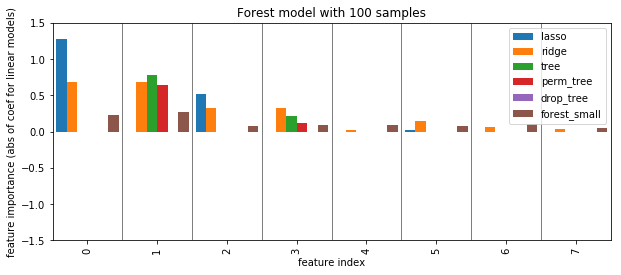

In [492]:
plot_importance({'lasso': np.abs(lasso_small.coef_), 'ridge': np.abs(ridge_small.coef_), 'tree': grid_tree_small.best_estimator_.feature_importances_,
                 'perm_tree': perm_tree_small, 'drop_tree': drop_tree_small, 'forest_small': rf_small.feature_importances_})
plt.ylabel("feature importance (abs of coef for linear models)")
plt.title("Forest model with 100 samples")
plt.savefig("images/forest_less_data_all.png")

In [493]:
perm_forest_small = permutation_importance(rf, X_test_small, y_test_small).mean(axis=1)

In [ ]:
shap_forest_small = shap_trees(rf, X_train_small, X_test_small)

In [ ]:
plot_importance({'lasso': np.abs(lasso_small.coef_), 'ridge': np.abs(ridge_small.coef_), 'tree': grid_tree_small.best_estimator_.feature_importances_,
                 'perm_tree': perm_tree_small, 'drop_tree': drop_tree_small, 'forest_small': rf_small.feature_importances_,
                 'perm_forest': perm_forest_small, 'shap_forest': shap_forest_small})
plt.ylabel("feature importance (abs of coef for linear models)")
plt.title("Forest model with 100 samples")
plt.savefig("images/forest_less_data_all.png")

# Partial Dependence

In [61]:
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor

boston = load_boston()
X_train, X_test, y_train, y_test = train_test_split(
    boston.data, boston.target, random_state=0)

gbrt = GradientBoostingRegressor().fit(X_train, y_train)
gbrt.score(X_test, y_test)

0.8153923574592779

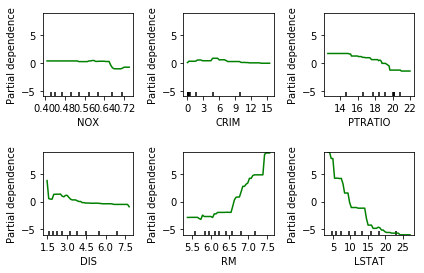

In [62]:
from sklearn.ensemble.partial_dependence import plot_partial_dependence
fig, axs = plot_partial_dependence(gbrt, X_train, np.argsort(gbrt.feature_importances_)[-6:],
                                       feature_names=boston.feature_names,
                                       n_jobs=3, grid_resolution=50)
plt.tight_layout()

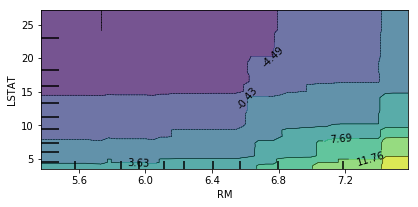

In [17]:
fig, axs = plot_partial_dependence(gbrt, X_train, [np.argsort(gbrt.feature_importances_)[-2:]],
                                   feature_names=boston.feature_names,

                                   n_jobs=3, grid_resolution=50)

0.9736842105263158

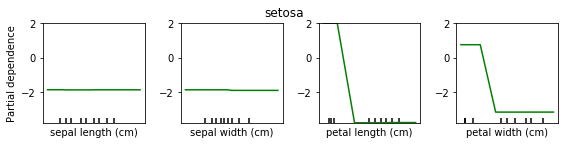

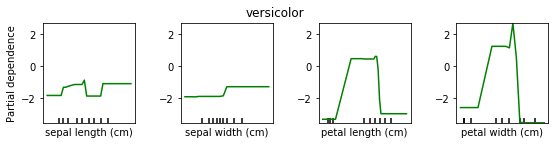

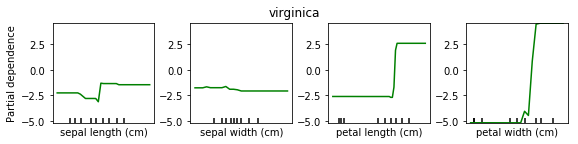

In [18]:
from sklearn.datasets import load_iris
from sklearn.ensemble import GradientBoostingClassifier


iris = load_iris()

X_train, X_test, y_train, y_test = train_test_split(
    iris.data, iris.target, stratify=iris.target, random_state=0)
gbrt_iris = GradientBoostingClassifier().fit(X_train, y_train)

for i in range(3):
    fig, axs = plot_partial_dependence(gbrt_iris, X_train, range(4), n_cols=4,
                                       feature_names=iris.feature_names, grid_resolution=50, label=i,
                                       figsize=(8, 2))
    fig.suptitle(iris.target_names[i])
    for ax in axs: ax.set_xticks(())
    for ax in axs[1:]: ax.set_ylabel("")

    plt.tight_layout()

gbrt_iris.score(X_test, y_test)


# ICEBox

In [38]:
from sklearn.datasets import make_blobs

In [143]:
X = np.random.normal(size=(2000, 3))

w = np.array([0, .5, .1])
y = np.dot(X, w) + np.random.normal(scale=0.3, size=(2000,))
mask = X[:, 0] > 0
#X[mask, 1] -= 2
y[mask] = 1 - y[mask]

[<matplotlib.lines.Line2D at 0x7fbe32e01320>]

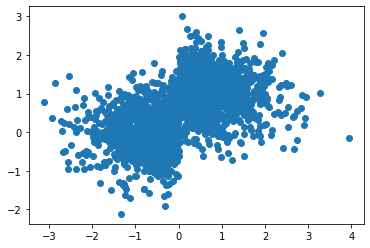

In [144]:
plt.plot(X[:, 0], y, 'o')

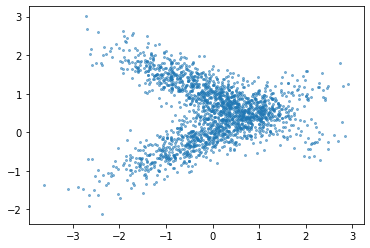

In [165]:
plt.scatter(X[:, 1], y, alpha=.5, s=4)
plt.savefig("images/pdp_failure_data.png")

(array([  1.,   1.,   3.,   6.,   8.,   9.,  23.,  35.,  58.,  64.,  88.,
        113., 133., 125., 150., 177., 171., 156., 151., 123., 105., 106.,
         72.,  57.,  29.,  18.,   8.,   4.,   4.,   1.,   1.]),
 array([-2.11751245, -1.95223387, -1.78695528, -1.62167669, -1.4563981 ,
        -1.29111951, -1.12584092, -0.96056234, -0.79528375, -0.63000516,
        -0.46472657, -0.29944798, -0.1341694 ,  0.03110919,  0.19638778,
         0.36166637,  0.52694496,  0.69222355,  0.85750213,  1.02278072,
         1.18805931,  1.3533379 ,  1.51861649,  1.68389508,  1.84917366,
         2.01445225,  2.17973084,  2.34500943,  2.51028802,  2.67556661,
         2.84084519,  3.00612378]),
 <a list of 31 Patch objects>)

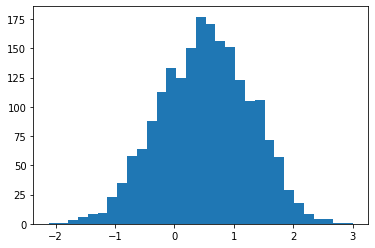

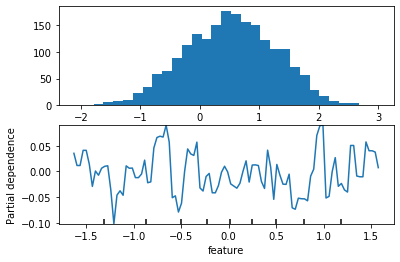

In [164]:
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.inspection import plot_partial_dependence
fig, axes = plt.subplots(2, 1)
axes[0].hist(y, bins='auto')
gb = HistGradientBoostingRegressor().fit(X, y)
pdp = plot_partial_dependence(gb, X, [1], ax=axes[1])
plt.xlabel("feature")
plt.savefig("images/pdp_failure.png")

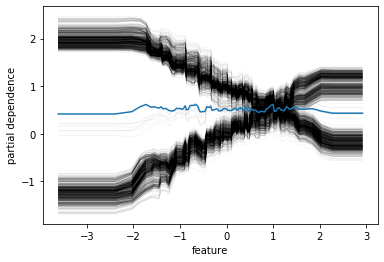

In [161]:
from pycebox.ice import ice, ice_plot
ice_df = ice(pd.DataFrame(X), 1, gb.predict, num_grid_points=100)
ice_plot(ice_df, frac_to_plot=1, plot_pdp=True,
         c='k', alpha=0.1, linewidth=0.3)
plt.ylabel("partial dependence")
plt.xlabel("feature")
plt.savefig("images/ice_cross.png")

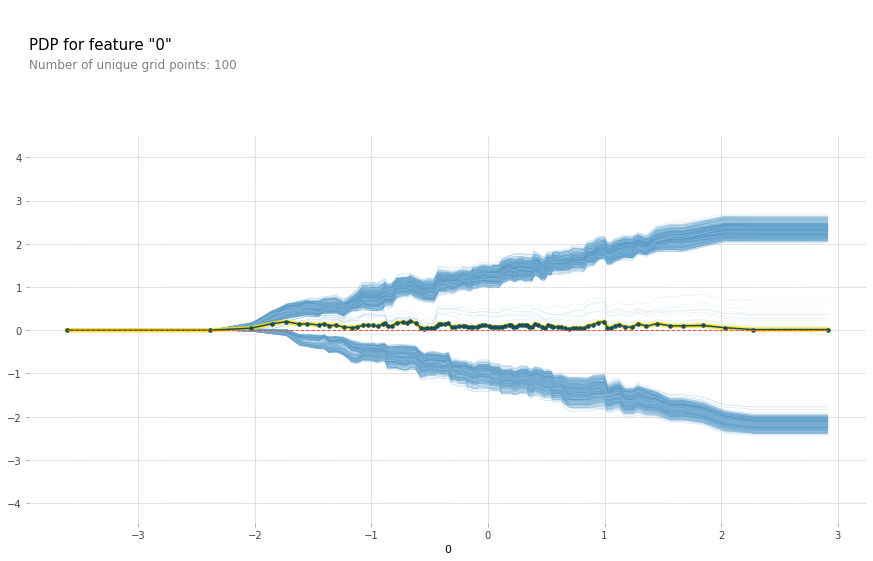

In [152]:
from pdpbox import pdp

feature_isolate = pdp.pdp_isolate(gb, pd.DataFrame(X), [0, 1, 2], 1, num_grid_points=100)
fig, axes = pdp.pdp_plot(feature_isolate, 0, plot_lines=True, frac_to_plot=1)

In [89]:
from pdpbox import pdp

boston = load_boston()
X_train, X_test, y_train, y_test = train_test_split(
    boston.data, boston.target, random_state=0)

gbrt = GradientBoostingRegressor().fit(X_train, y_train)
gbrt.score(X_test, y_test)

NameError: name 'load_boston' is not defined

In [30]:
X_train_df = pd.DataFrame(X_train, columns=boston.feature_names)

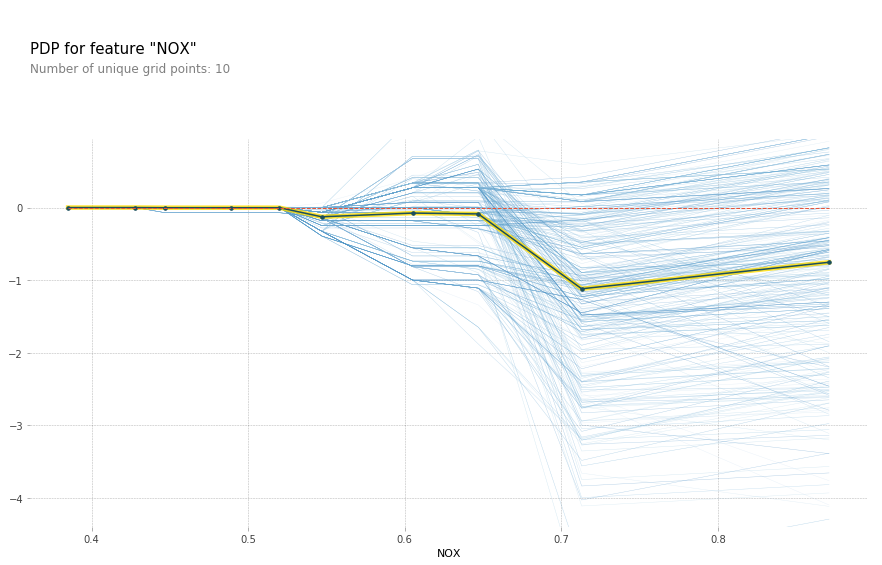

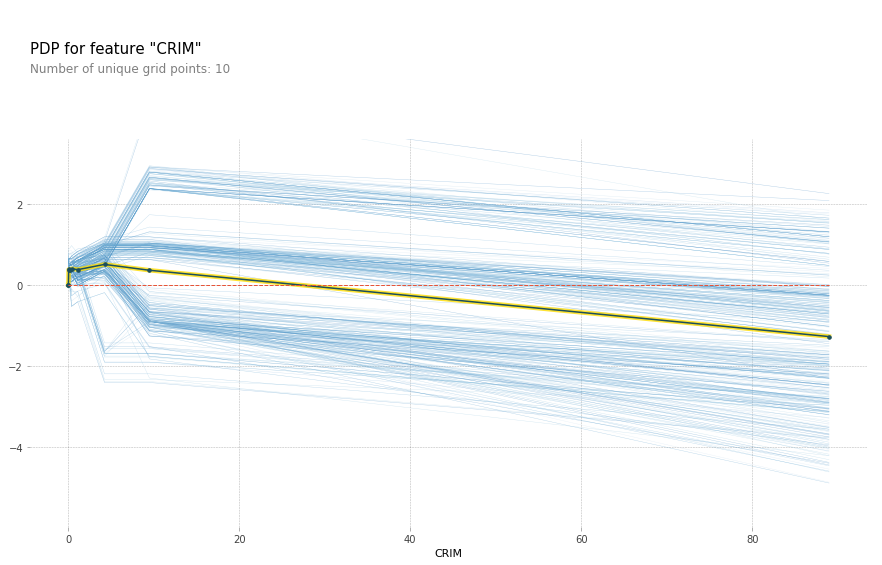

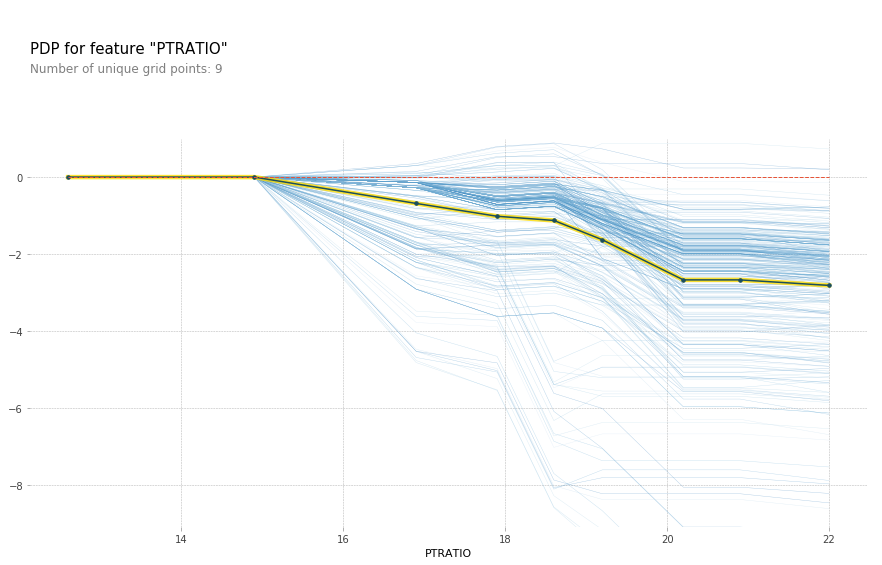

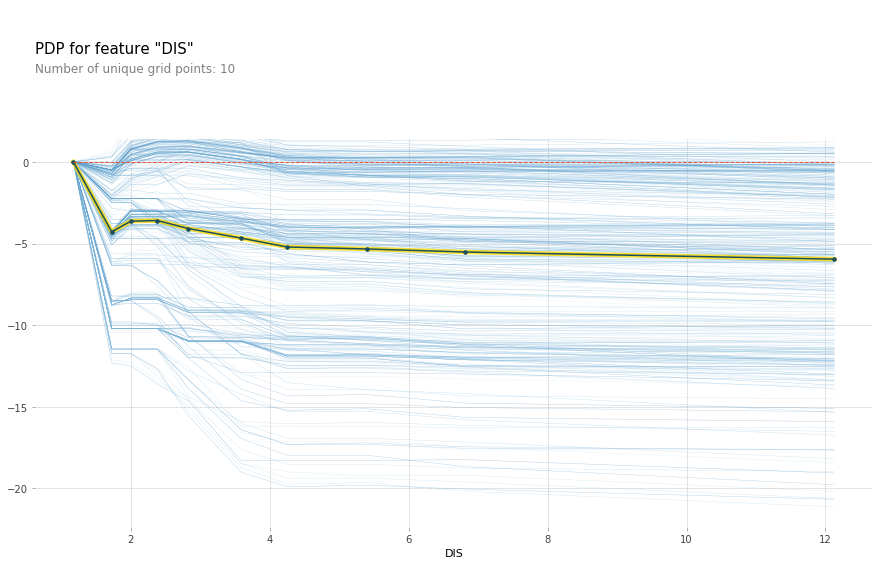

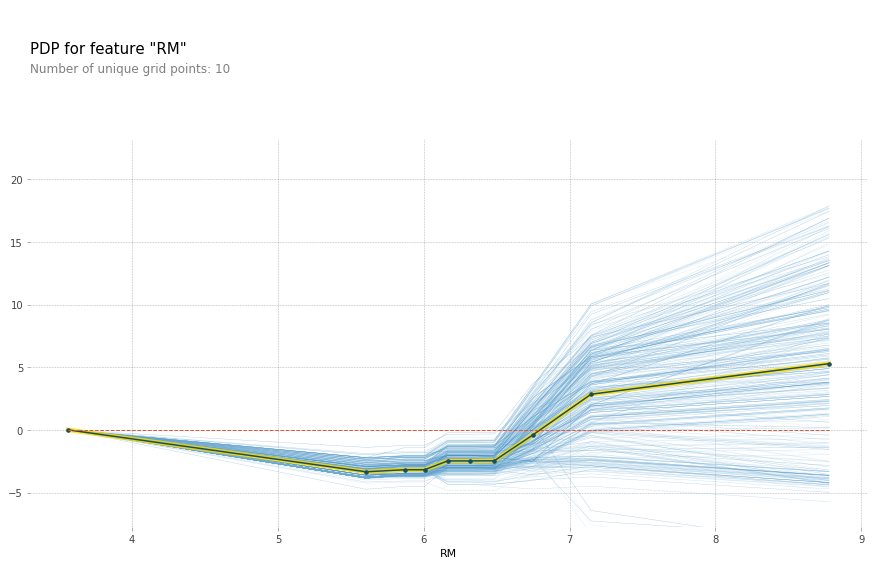

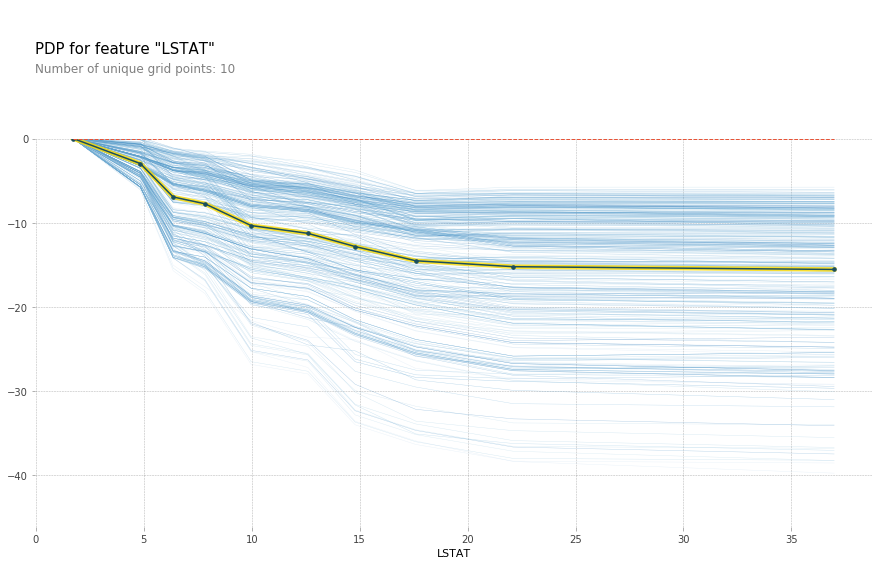

In [63]:
features_of_interest = boston.feature_names[np.argsort(gbrt.feature_importances_)[-6:]]
for feature in features_of_interest:
    feature_isolate = pdp.pdp_isolate(gbrt, X_train_df, X_train_df.columns, feature)
    fig, axes = pdp.pdp_plot(feature_isolate, feature, plot_lines=True, frac_to_plot=1)


Index(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
       'PTRATIO', 'B', 'LSTAT'],
      dtype='object')

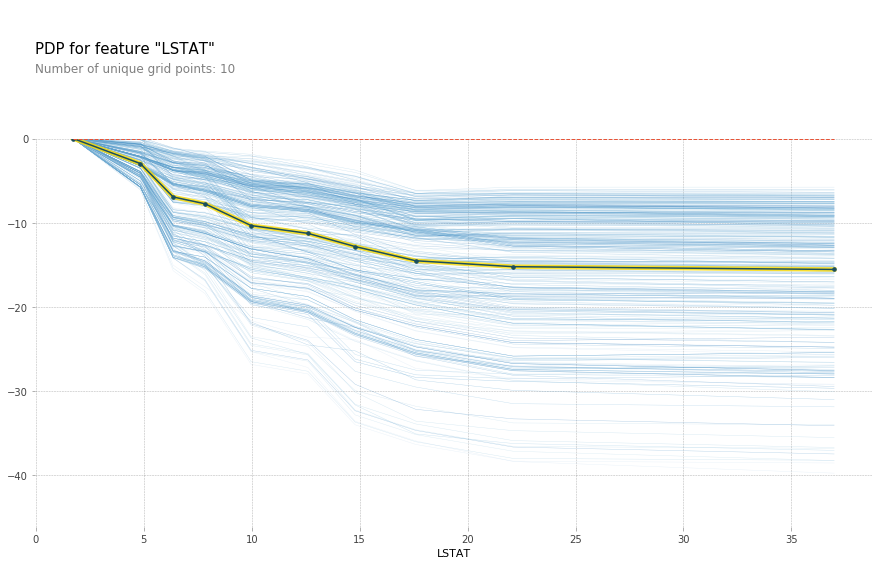

In [65]:
feature = 'LSTAT'
feature_isolate = pdp.pdp_isolate(gbrt, X_train_df, X_train_df.columns, feature)
fig, axes = pdp.pdp_plot(feature_isolate, feature, plot_lines=True, frac_to_plot=1)
fig.savefig("images/ice_lstat.png")

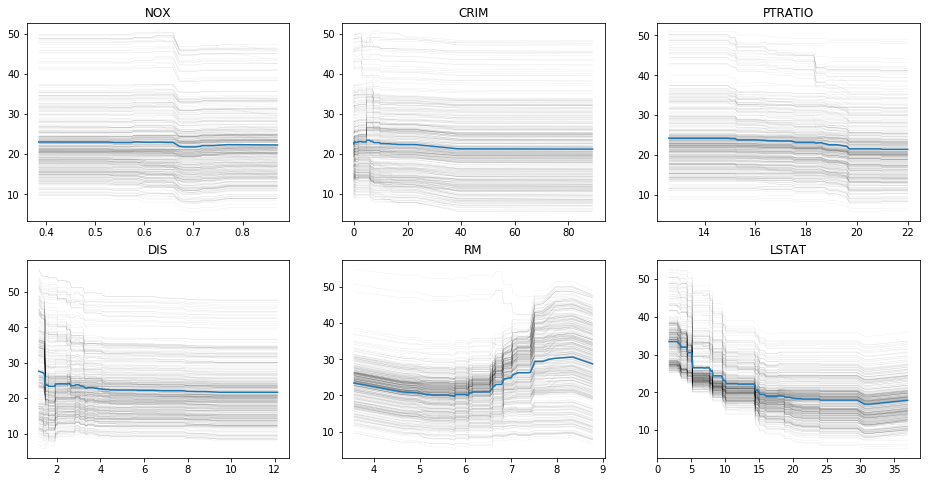

In [64]:
# yet another library
from pycebox.ice import ice, ice_plot
fig, axes = plt.subplots(2, 3, figsize=(16, 8))
for feature, ax in zip(features_of_interest, axes.ravel()):
    ice_df = ice(X_train_df, feature, gbrt.predict, num_grid_points=100)
    ice_plot(ice_df, frac_to_plot=10, plot_pdp=True,
             c='k', alpha=0.1, linewidth=0.3, ax=ax)
    ax.set_title(feature)
plt.savefig("images/boston_ice.png")

# Feature Selection

In [7]:
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split

In [8]:
boston = load_boston()
X, y = boston.data, boston.target
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [9]:
from sklearn.preprocessing import scale
X_train_scaled = scale(X_train)
cov = np.cov(X_train_scaled, rowvar=False)

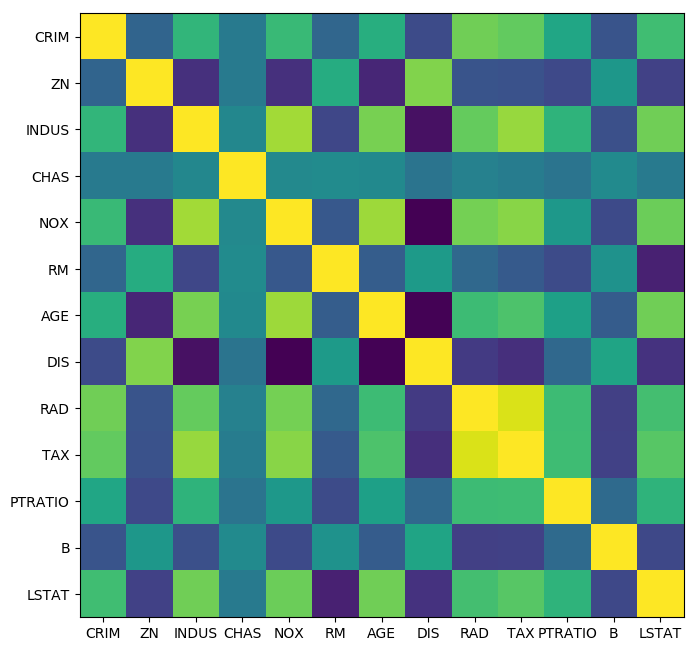

In [10]:
plt.figure(figsize=(8, 8), dpi=100)
plt.imshow(cov)
plt.xticks(range(X.shape[1]), boston.feature_names)
plt.yticks(range(X.shape[1]), boston.feature_names);

In [11]:
from scipy.cluster import hierarchy
order = np.array(hierarchy.dendrogram(hierarchy.ward(cov), no_plot=True)['ivl'], dtype="int")

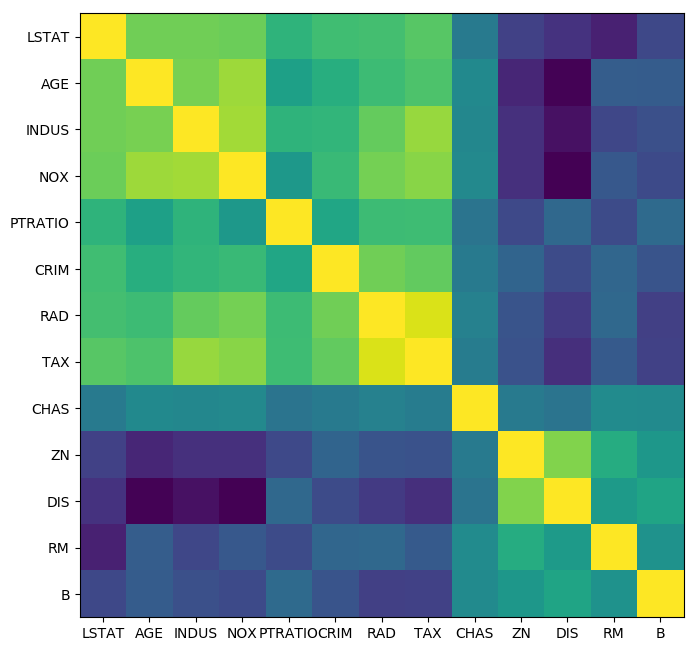

In [12]:
plt.figure(figsize=(8, 8), dpi=100)
plt.imshow(cov[order, :][:, order])
plt.xticks(range(X.shape[1]), boston.feature_names[order])
plt.yticks(range(X.shape[1]), boston.feature_names[order]);

# Supervised feature selection

In [13]:
from sklearn.feature_selection import f_regression
f_values, p_values = f_regression(X, y)

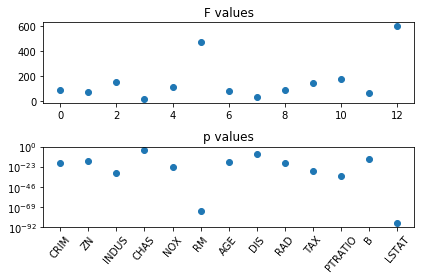

In [14]:
fig, ax = plt.subplots(2, 1)
ax[0].set_title("F values")
ax[0].plot(f_values, 'o')
ax[1].set_title("p values")
ax[1].plot(p_values, 'o')
ax[1].set_yscale("log")

ax[1].set_xticks(range(X.shape[1]))
ax[1].set_xticklabels(boston.feature_names, rotation=50);
fig.tight_layout()

In [15]:
from sklearn.feature_selection import SelectKBest, SelectPercentile, SelectFpr
from sklearn.linear_model import RidgeCV

select = SelectKBest(k=2, score_func=f_regression)
select.fit(X_train, y_train)
print(X_train.shape)
print(select.transform(X_train).shape)

(379, 13)
(379, 2)


In [19]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
all_features = make_pipeline(StandardScaler(), RidgeCV())
select_2 = make_pipeline(StandardScaler(), SelectKBest(k=2, score_func=f_regression), RidgeCV())

In [21]:
from sklearn.model_selection import cross_val_score
np.mean(cross_val_score(all_features, X_train, y_train, cv=10))

0.71795885107509

In [22]:
np.mean(cross_val_score(select_2, X_train, y_train, cv=10))

0.6243625749168433

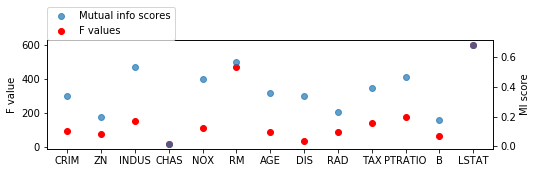

In [23]:
from sklearn.feature_selection import mutual_info_regression
scores = mutual_info_regression(X_train, y_train, discrete_features=[3])

fig = plt.figure(figsize=(8, 2))
line_f, = plt.plot(f_values, 'o', c='r')
plt.ylabel("F value")
ax2 = plt.twinx()
line_s, = ax2.plot(scores, 'o', alpha=.7)
ax2.set_ylabel("MI score")
plt.xticks(range(X.shape[1]), boston.feature_names)
plt.legend([line_s, line_f], ["Mutual info scores", "F values"], loc=(0, 1))

In [35]:
from sklearn.linear_model import Lasso
X_train_scaled = scale(X_train)
lasso = LassoCV().fit(X_train_scaled, y_train)
print(lasso.coef_)

[-0.          0.         -0.          0.         -0.          2.52933025
 -0.         -0.         -0.         -0.22763148 -1.70088382  0.13186059
 -3.60565498]


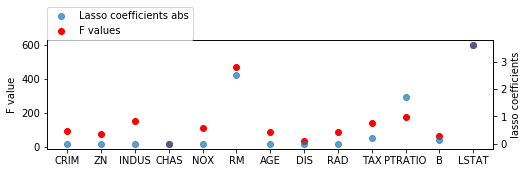

In [36]:
fig = plt.figure(figsize=(8, 2))
line_f, = plt.plot(f_values, 'o', c='r')
plt.ylabel("F value")
ax2 = plt.twinx()
ax2.set_ylabel("lasso coefficients")
line_s, = ax2.plot(np.abs(lasso.coef_), 'o', alpha=.7)
plt.xticks(range(X.shape[1]), boston.feature_names)
plt.legend([line_s, line_f], ["Lasso coefficients abs", "F values"], loc=(0, 1))

In [37]:
from sklearn.linear_model import Lasso
X_train_scaled = scale(X_train)
lasso = Lasso().fit(X_train_scaled, y_train)
print(lasso.coef_)

[-0.          0.         -0.          0.         -0.          2.52933025
 -0.         -0.         -0.         -0.22763148 -1.70088382  0.13186059
 -3.60565498]


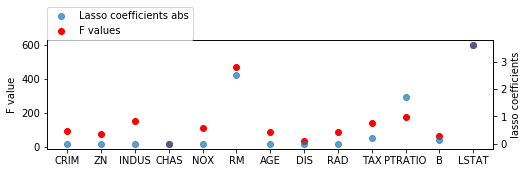

In [38]:
fig = plt.figure(figsize=(8, 2))
line_f, = plt.plot(f_values, 'o', c='r')
plt.ylabel("F value")
ax2 = plt.twinx()
ax2.set_ylabel("lasso coefficients")
line_s, = ax2.plot(np.abs(lasso.coef_), 'o', alpha=.7)
plt.xticks(range(X.shape[1]), boston.feature_names)
plt.legend([line_s, line_f], ["Lasso coefficients abs", "F values"], loc=(0, 1))

In [40]:
X_train.shape

(379, 13)

In [44]:
from sklearn.feature_selection import SelectFromModel
select_lassocv = SelectFromModel(LassoCV())
select_lassocv.fit(X_train, y_train)
print(select_lassocv.transform(X_train).shape)

(379, 11)


In [45]:
pipe_lassocv = make_pipeline(StandardScaler(), select_lassocv, RidgeCV())
np.mean(cross_val_score(pipe_lassocv, X_train, y_train, cv=10))

0.7171231551882247

In [79]:
np.mean(cross_val_score(all_features, X_train, y_train, cv=10))

0.71798347520832284

In [68]:
# could grid-search alpha in lasso
select_lasso = SelectFromModel(Lasso())
pipe_lasso = make_pipeline(StandardScaler(), select_lasso, RidgeCV())
np.mean(cross_val_score(pipe_lasso, X_train, y_train, cv=10))

0.67051240477576868

In [69]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE

# create ranking among all features by selecting only one
rfe = RFE(LinearRegression(), n_features_to_select=1)
rfe.fit(X_train_scaled, y_train)
rfe.ranking_

array([ 9,  8, 13, 11,  5,  2, 12,  4,  7,  6,  3, 10,  1])

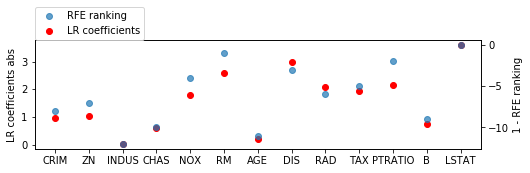

In [70]:
lr = LinearRegression().fit(X_train_scaled, y_train)
fig = plt.figure(figsize=(8, 2))
line_f, = plt.plot(np.abs(lr.coef_), 'o', c='r')
plt.ylabel("LR coefficients abs")
ax2 = plt.twinx()
ax2.set_ylabel("1 - RFE ranking")
line_s, = ax2.plot(1 - rfe.ranking_, 'o', alpha=.7)
plt.xticks(range(X.shape[1]), boston.feature_names)
plt.legend([line_s, line_f], ["RFE ranking", "LR coefficients"], loc=(0, 1))

In [71]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFECV

rfe = RFECV(LinearRegression(), cv=10)
rfe.fit(X_train_scaled, y_train)
print(rfe.support_)
print(boston.feature_names[rfe.support_])

[ True  True False  True  True  True False  True  True  True  True  True
  True]
['CRIM' 'ZN' 'CHAS' 'NOX' 'RM' 'DIS' 'RAD' 'TAX' 'PTRATIO' 'B' 'LSTAT']


In [72]:
pipe_rfe_ridgecv = make_pipeline(StandardScaler(), RFECV(LinearRegression(), cv=10), RidgeCV())
np.mean(cross_val_score(pipe_rfe_ridgecv, X_train, y_train, cv=10))

0.71019583375843598

In [73]:
from sklearn.preprocessing import PolynomialFeatures
pipe_rfe_ridgecv = make_pipeline(StandardScaler(), PolynomialFeatures(), RFECV(LinearRegression(), cv=10), RidgeCV())
np.mean(cross_val_score(pipe_rfe_ridgecv, X_train, y_train, cv=10))

0.82031507795494429

In [74]:
pipe_rfe_ridgecv.fit(X_train, y_train)
print(pipe_rfe_ridgecv.named_steps['rfecv'].support_)

[False  True  True  True False  True  True  True False  True  True False
  True  True False  True  True  True  True False False False  True  True
  True False False  True  True False  True False False False False  True
  True  True False  True False False False  True  True  True  True  True
  True  True False  True False False  True False False False  True False
 False False  True  True  True  True  True False False False  True  True
 False  True  True False False False False  True  True False  True  True
  True  True False False  True  True  True  True  True  True  True  True
  True False  True False  True False False False  True]


In [75]:
from mlxtend.feature_selection import SequentialFeatureSelector
sfs = SequentialFeatureSelector(LinearRegression(), forward=False, k_features=7)
sfs.fit(X_train_scaled, y_train)

ModuleNotFoundError: No module named 'mlxtend'

In [ ]:
print(sfs.k_feature_idx_)
print(boston.feature_names[np.array(sfs.k_feature_idx_)])

In [ ]:
sfs.k_score_